In [26]:
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm, tqdm_notebook
import random
import time
import glob

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec

from sklearn.cluster import KMeans,MiniBatchKMeans, Birch,MeanShift, estimate_bandwidth,SpectralClustering, DBSCAN,OPTICS,cluster_optics_dbscan
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn import preprocessing, metrics
from sklearn.metrics.pairwise import pairwise_distances_argmin
import PIL
from PIL import Image

from itertools import permutations
from itertools import cycle
import time

In [2]:
# data_extracted = pd.read_csv("D:\Codes\Spotify API\data.csv")
# spotify_data = pd.read_csv("D:\Codes\Spotify API\data111\data111.csv")
track_features = pd.read_csv("D:\Codes\Spotify API/tracks_features.csv", nrows=300000)

data=track_features[['name', 'year', 'explicit', 'duration_ms', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']]
data.describe()

,year,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,300000.000000,3.000000e+05,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,2003.824187,2.489531e+05,0.488763,0.507327,5.206873,-11.864282,0.683987,0.080718,0.452611,0.285770,0.200402,0.436523,117.617257,3.828513
std,9.183343,1.492836e+05,0.185042,0.293761,3.527521,6.824779,0.464919,0.115335,0.384477,0.376454,0.179943,0.271015,30.979273,0.568061
min,1909.000000,1.000000e+03,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2000.000000,1.762958e+05,0.355000,0.251000,2.000000,-15.181000,0.000000,0.034500,0.040000,0.000011,0.096500,0.199000,94.258750,4.000000
50%,2005.000000,2.276530e+05,0.496000,0.515000,5.000000,-10.003000,1.000000,0.043600,0.410000,0.009930,0.124000,0.415000,116.286500,4.000000
75%,2009.000000,2.882270e+05,0.625000,0.765000,8.000000,-6.913000,1.000000,0.068000,0.861000,0.722000,0.242000,0.655000,136.932250,4.000000
max,2020.000000,6.054655e+06,0.990000,1.000000,11.000000,4.651000,1.000000,0.969000,0.996000,1.000000,1.000000,1.000000,246.130000,5.000000


In [3]:
def scaler (data):
       x = data.iloc[:,1:]
       min_max_scaler = preprocessing.MinMaxScaler()
       x_scaled = min_max_scaler.fit_transform(x)
       df1 = pd.DataFrame(x_scaled)
       return df1

data_scaled=scaler(data)

def pca (labels,nrow=300000,data_scaled=data_scaled):
       data_scaled=data_scaled.iloc[:nrow,:]
       pca =PCA(n_components=2).fit(data_scaled)
       data_scaled_pca = pca.transform(data_scaled)
       data_scaled_pca = pd.DataFrame(data_scaled_pca)
       data_scaled_pca.rename(columns={0:'x',1:'y'},inplace=True)
       data_scaled_pca['label']= labels
       return data_scaled_pca

In [4]:

print(data.columns)
x=data.iloc[:,1:]
print(x.columns)

Index(['name', 'year', 'explicit', 'duration_ms', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature'],
      dtype='object')
Index(['year', 'explicit', 'duration_ms', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature'],
      dtype='object')


## K-Means

In [5]:
kmeans = KMeans(init="k-means++",
                n_clusters=9,
                random_state=15,
                max_iter = 500).fit(data_scaled)
scaled_data_pca=pca(labels=kmeans.labels_)


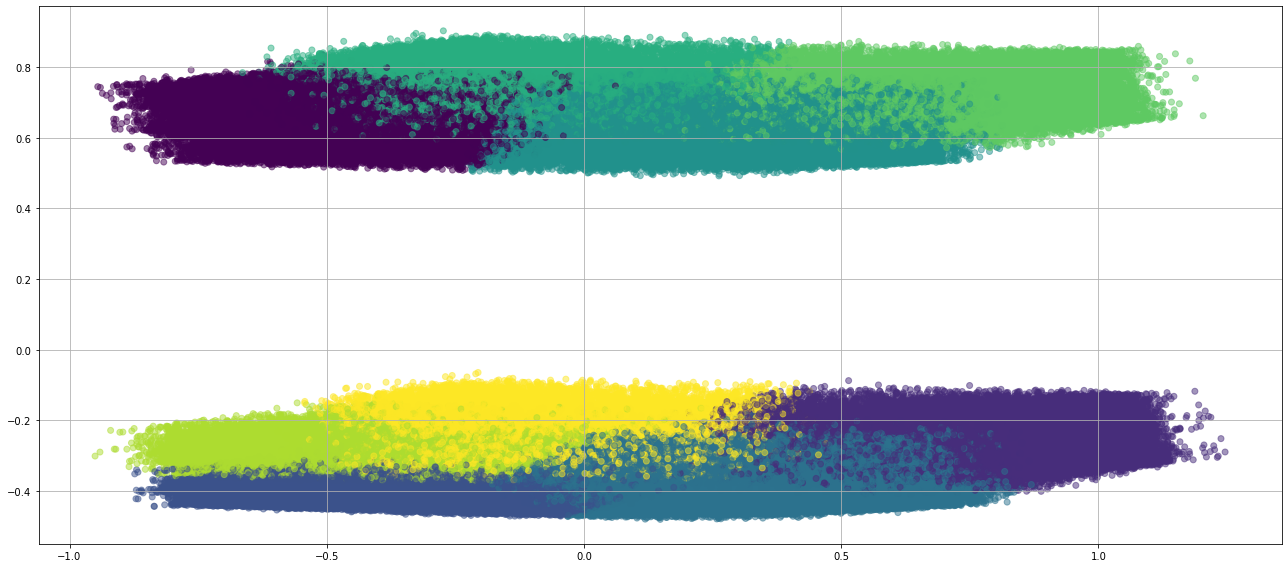

In [6]:
plt.rcParams["figure.figsize"] = (18,8)
fig, ax = plt.subplots()

plt.scatter(scaled_data_pca['x'],scaled_data_pca['y'],c=scaled_data_pca['label'], alpha=0.5)
ax.grid(True)
fig.tight_layout()

## Mini Batch K-Means

In [7]:
mbk = MiniBatchKMeans(init='k-means++', n_clusters=9, batch_size=3845,
                    n_init=10, max_no_improvement=10, verbose=0).fit(data_scaled)
colors = ['#4EACC5', '#FF9C34', '#4E9A06']

scaled_data_pca=pca(labels=mbk.labels_)

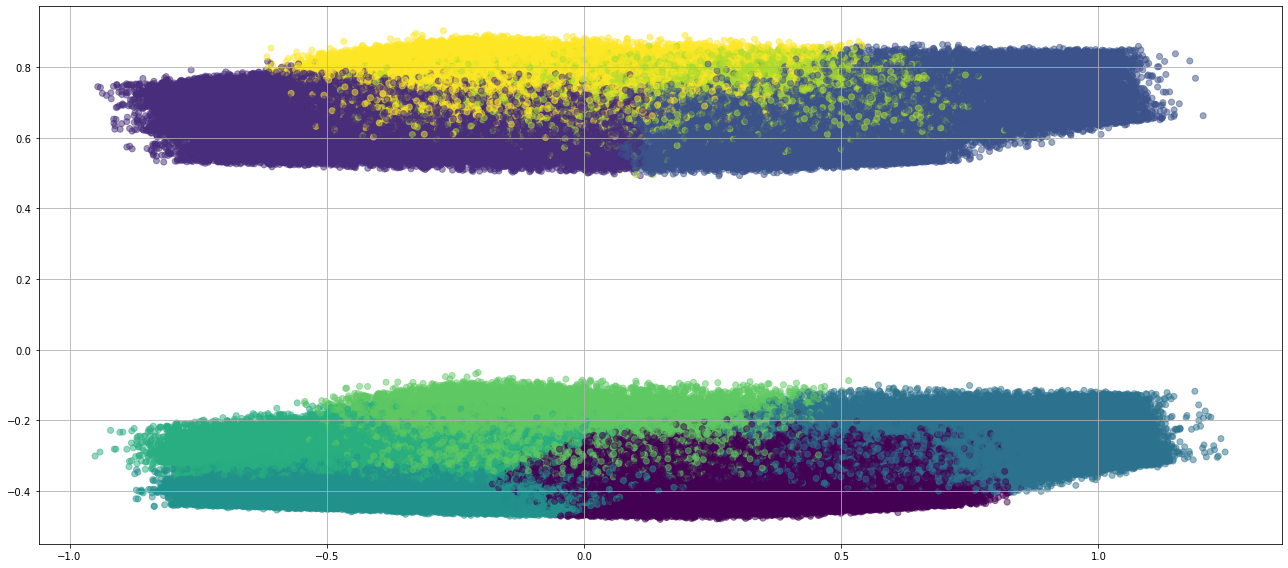

In [8]:
plt.rcParams["figure.figsize"] = (18,8)
fig, ax = plt.subplots()

plt.scatter(scaled_data_pca['x'],scaled_data_pca['y'],c=scaled_data_pca['label'], alpha=0.5)
ax.grid(True)
fig.tight_layout()

## BIRCH

n_clusters : 1


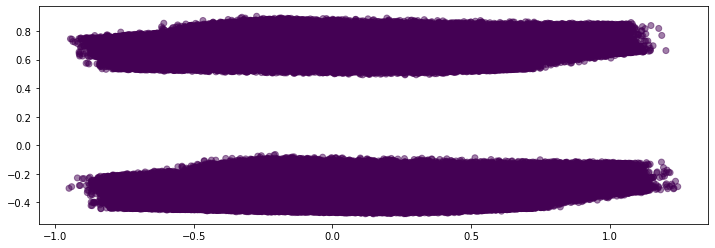

n_clusters : 9


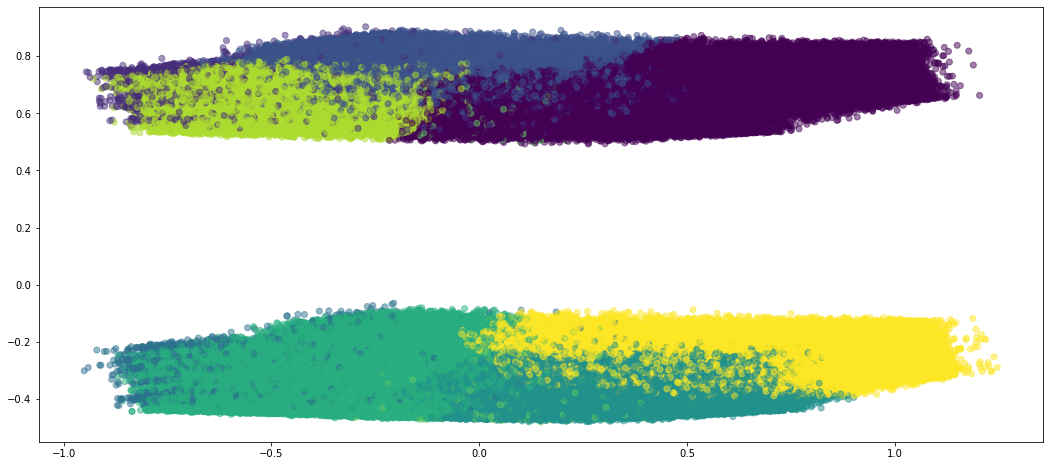

In [11]:
birch_models = [Birch(threshold=1.7, n_clusters=None),
                Birch(threshold=0.8, n_clusters=9)]
final_step = ['without global clustering', 'with global clustering']

colors_ = cycle(colors.cnames.keys())
fig = plt.figure(figsize=(12, 4))
#fig.subplots_adjust(left=0.04, right=0.98, bottom=0.1, top=0.9)
for ind, (birch_model, info) in enumerate(zip(birch_models, final_step)):
   
    birch_model.fit(data_scaled)
    # Plot result
    labels = birch_model.labels_
    centroids = birch_model.subcluster_centers_
    n_clusters = np.unique(labels).size
    print("n_clusters : %d" % n_clusters)

    scaled_data_pca_birch=pca(labels=birch_model.labels_)
    #ax = fig.add_subplot(1, 3, ind+1)
    plt.scatter(scaled_data_pca_birch['x'],scaled_data_pca_birch['y'],c=scaled_data_pca_birch['label'], alpha=0.5)
    plt.show()

# Density Model Clustering
## Mean Shift

In [12]:
bandwidth = estimate_bandwidth(data_scaled, quantile=0.2, n_samples=500)
print('Bandwidth : {}'.format(bandwidth))
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(data_scaled.iloc[0:10000,:])

Bandwidth : 1.024269909879463


MeanShift(bandwidth=1.024269909879463, bin_seeding=True)

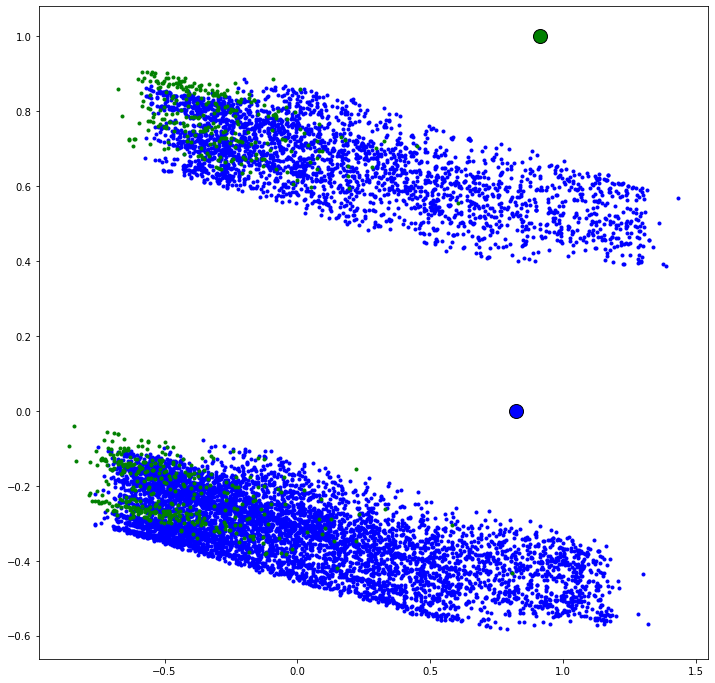

In [13]:
plt.rcParams['agg.path.chunksize'] = 200

labels = ms.labels_
cluster_centers = ms.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

plt.figure(1, figsize=(12,12))
colors=cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')

scaled_data_pca_meanshift=pca(labels=ms.labels_, nrow=10000)

for k, col in zip(range(n_clusters_),colors):
    #my_members= scaled_data_pca_meanshift[labels==k]
    my_members=labels==k
    cluster_center = cluster_centers[k]
    plt.plot(scaled_data_pca_meanshift.iloc[my_members, 0], scaled_data_pca_meanshift.iloc[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=14)

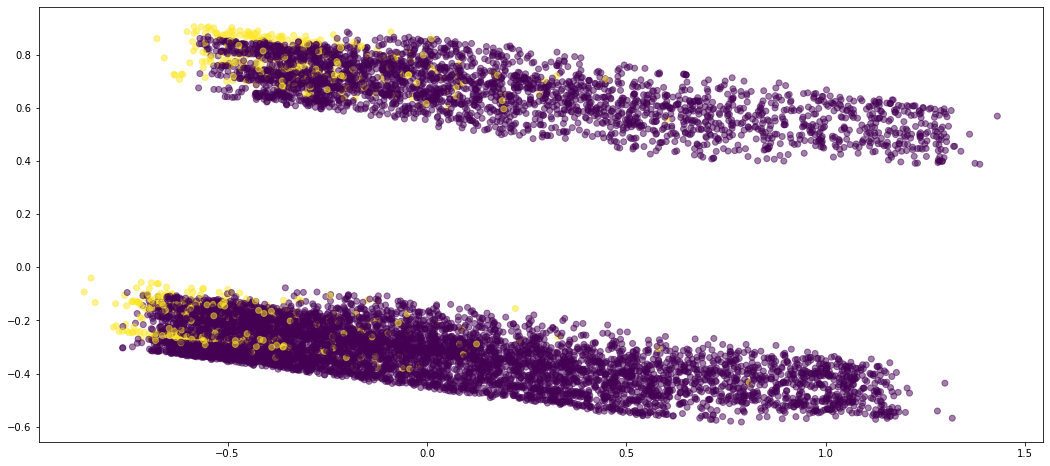

In [14]:
 plt.scatter(scaled_data_pca_meanshift['x'],scaled_data_pca_meanshift['y'],c=scaled_data_pca_meanshift['label'], alpha=0.5)

## Spectral Clustering

In [16]:
clustering = SpectralClustering(n_clusters=9, assign_labels='discretize', random_state=0).fit(data_scaled.iloc[0:20000,:])

Searching for k : 1


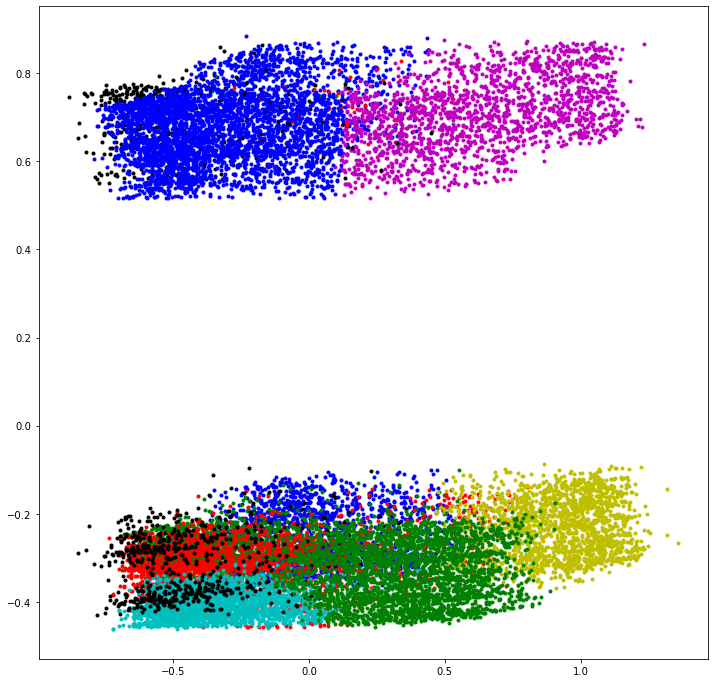

In [17]:
X=data_scaled.iloc[0:20000,:]

plt.figure(1 ,figsize=(12,12))
plt.clf()
labels = clustering.labels_
labels_unique = np.unique(labels)

scaled_data_pca_sc= pca(labels=clustering.labels_, nrow=20000)

print('Searching for k : {}'.format(k))
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(len(labels_unique)), colors):
    my_members = labels == k
    plt.plot(scaled_data_pca_sc.iloc[my_members, 0], scaled_data_pca_sc.iloc[my_members, 1], col + '.')
plt.show()

## DBSCAN

In [18]:
x = data.iloc[0:50000,1:]
standard_scaler = preprocessing.StandardScaler()
x_scaled = standard_scaler.fit_transform(x)
standard_scaled = pd.DataFrame(x_scaled)

y=data_scaled.iloc[:25000,:]

In [19]:
db = DBSCAN(eps=0.3, min_samples=1200, metric='cosine').fit(standard_scaled)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [20]:
scaled_data_pca_dbscan= pca(labels=db.labels_, nrow=50000,data_scaled=standard_scaled)

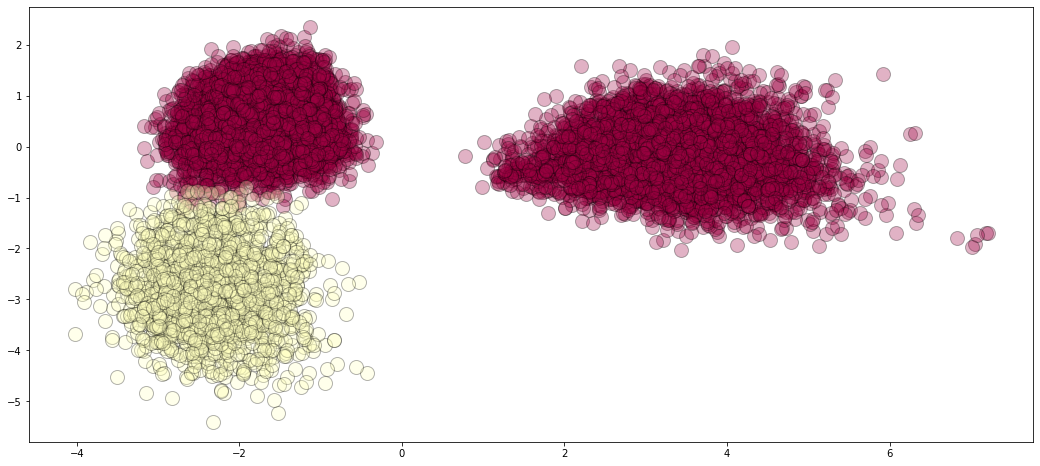

In [21]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0,1,len(unique_labels))]

for k, col in zip(unique_labels , colors ):
    if k ==-1:
        col=[0,0,0,1]
    class_member_mask = (labels==k)
    xy = scaled_data_pca_dbscan [ class_member_mask & core_samples_mask ]
    plt.plot(xy.iloc[:,0],xy.iloc[:,1],'o',markerfacecolor=tuple(col),markeredgecolor='k',markersize=14, alpha=0.3)

## OPTICS

In [67]:
X=standard_scaled.iloc[:10000,:]
clust = OPTICS(min_samples=200, xi=.15, min_cluster_size=.15).fit(X)


In [68]:
labels_050 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=0.5)
labels_200 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=2.75)
pca_optics= pca (labels=labels_200,nrow=10000,data_scaled=standard_scaled.iloc[:10000,:])
X=pca_optics

space = np.arange(len(X))
reachability = clust.reachability_[clust.ordering_]
#labels = clust.labels_[clust.ordering_]

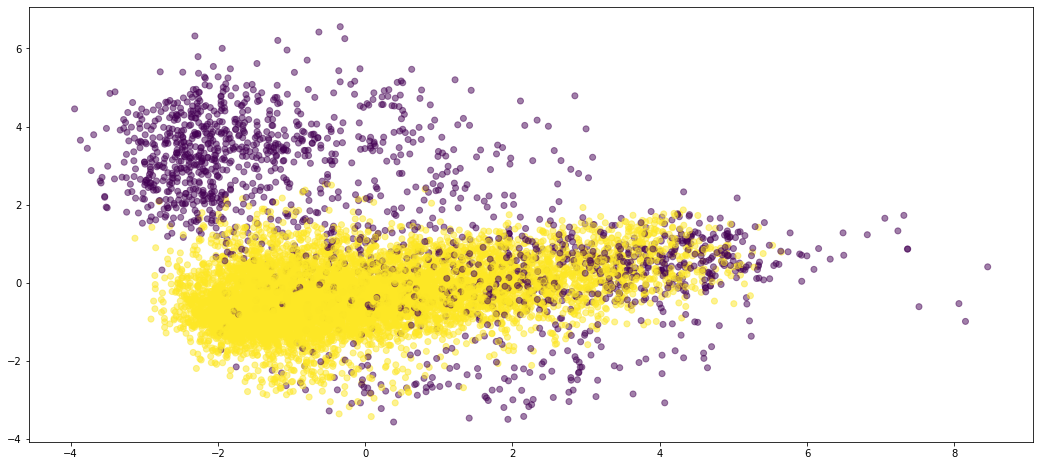

In [69]:
plt.scatter(pca_optics['x'],pca_optics['y'],c=pca_optics['label'], alpha=0.5)
plt.show()

## KNN

In [ ]:
neighbors = NearestNeighbors(n_neighbors=5,
                             algorithm='ball_tree').fit(feature_list)

## ANNOY
